In [6]:
import sys
import os
import pickle
from tqdm import tqdm
sys.path.append(os.path.join(os.path.expanduser('~'), 'projects'))
import j_utils.munging as mg
from lendingclub.lc_utils import gen_datasets
import seaborn as sns

pd.options.display.max_columns = 999
pd.options.display.max_rows = 60
pd.options.display.max_seq_items = None

ppath = os.path.join(os.path.expanduser('~'), 'projects', 'lendingclub', )
dpath = os.path.join(ppath,'data')

# testing
from pandas.testing import assert_frame_equal

In [2]:
base_loan_info = pd.read_feather(os.path.join(dpath, 'base_loan_info.fth'))
eval_loan_info = pd.read_feather(os.path.join(dpath, 'eval_loan_info_scored.fth'))
# npv_roi_df = pd.read_feather(os.path.join(dpath, 'npv_roi_df.fth'))

In [3]:
max_date = eval_loan_info['issue_d'].max()
start = pd.to_datetime('2008-01-01')
test_dates = [start]
while start < max_date:
    start += pd.DateOffset(months=12)
    if start < max_date:
        test_dates.append(start)
test_dates

[Timestamp('2008-01-01 00:00:00'),
 Timestamp('2009-01-01 00:00:00'),
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00')]

# for each model, 
1) compare top30% of all test in aggregate
2) compare month-by-month top30%
3) compare bootstrap month-by-month top30%

## baselines

In [4]:
def get_top30_ret(model, eval_df, return_col='0.07', bootstrap=False):
    '''
    Picks loans and get returns based on maximizing model_score
    '''
    if bootstrap:
        eval_df = eval_df.sample(frac=1, replace=True)
    return eval_df.nlargest(round(len(eval_df)*.3), f'{model}_score')['0.07'].mean()

def get_mbm_top30_ret(model, eval_df, return_col='0.07', bootstrap=False):
    issue_d_g = eval_df.groupby('issue_d')
    res_d = {}
    for d, g in issue_d_g:
        res_d[d] = get_top30_ret(model, g, bootstrap=bootstrap)
    return res_d

In [14]:
fres_dict = {}
for test_date in tqdm(test_dates):
    res_dict = {}
    today = test_date + pd.DateOffset(months=-1)
    
    # get 2 sets of data, test_ids for done loans, and test_old_ids (old and done)
    _, _, test_x, test_y, _, test_ids = gen_datasets(today, test_date, base_loan_info, eval_loan_info, '0.07')
    # train model using train_x, train_y (skip for baselines)
    # score test_x with model (skip for baselines)
    
    # setup eval_loan_info for the returns calculations
    eval_df = eval_loan_info.query('id == @test_ids')
    
    # setup dicts
    wt30_d = {}
    mbmt30_d = {}
    bsmbmt30_d = {}
    
    for model in ['baseline', 'A', 'B', 'C', 'D', 'E', 'F', 'G']:
        # Given the whole test set, get the returns of top 30%
        wt30_d[model] = get_top30_ret(model, eval_df)
        
        # given whole test set, get m-by-m returns of top 30% each month
        mbmt30_d[model] = get_mbm_top30_ret(model, eval_df)
        
        # given whole test set, get bootstrap m-by-m returns of top30% each month
        bsmbm_d = {}
        for i in np.arange(100):
            bsmbm_d[i] = get_mbm_top30_ret(model, eval_df, bootstrap=True)
            
        bsmbmt30_d[model] = bsmbm_d
        reform = {(outerKey, innerKey): values for outerKey, innerDict in 
                   bsmbmt30_d.items() for innerKey, values in innerDict.items()}    
        
    res_dict['whole_top30'] = wt30_d
    res_dict['mbm_top30'] = mbmt30_d
    res_dict['bsmbm_top30'] = reform #bsmbmt30_d
    fres_dict[test_date] = res_dict

100%|██████████| 12/12 [2:00:58<00:00, 261.63s/it] 


In [28]:
# save the fres_dict as a pickle
with open(os.path.join(dpath,'model_returns_dict.pkl'), 'wb') as handle:
    pickle.dump(fres_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

In [7]:
# load in
with open(os.path.join(dpath,'model_returns_dict.pkl'), 'rb') as handle:
    fres_dict = pickle.load(handle)

In [8]:
# make plots over time
whole_top30 = {}
mbm_top30 = {}
bsmbm_top30 = {}
for date in fres_dict.keys():
    whole_top30[date] = fres_dict[date]['whole_top30']
    mbm_top30[date] = fres_dict[date]['mbm_top30']
    bsmbm_top30[date] = fres_dict[date]['bsmbm_top30']
# reshape some dataframes

Text(0, 0.5, '.07 discounted returns')

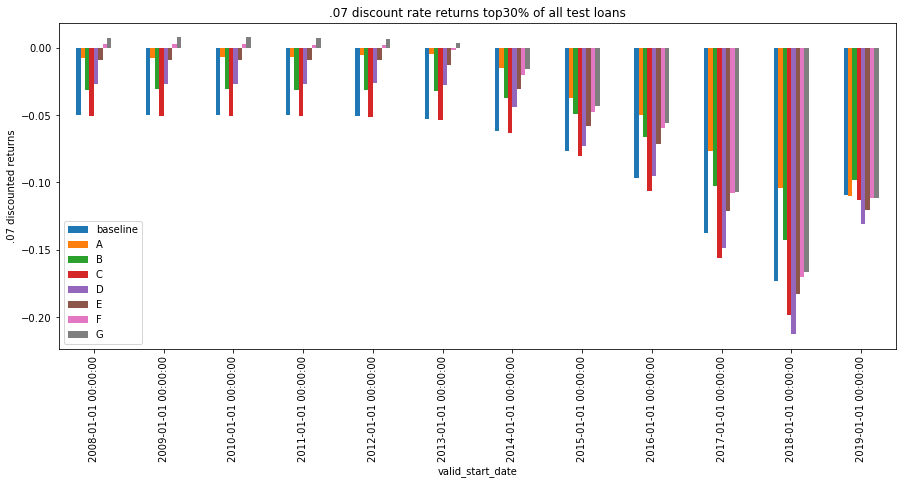

In [9]:
# whole_top30
whole_top30_df = pd.DataFrame(whole_top30).T
whole_top30_df.to_csv(os.path.join(dpath, 'whole_top30_df.csv'))
ax = whole_top30_df.plot(kind='bar', figsize=(15,6), title='.07 discount rate returns top30% of all test loans')
ax.set_xlabel('valid_start_date')
ax.set_ylabel('.07 discounted returns')

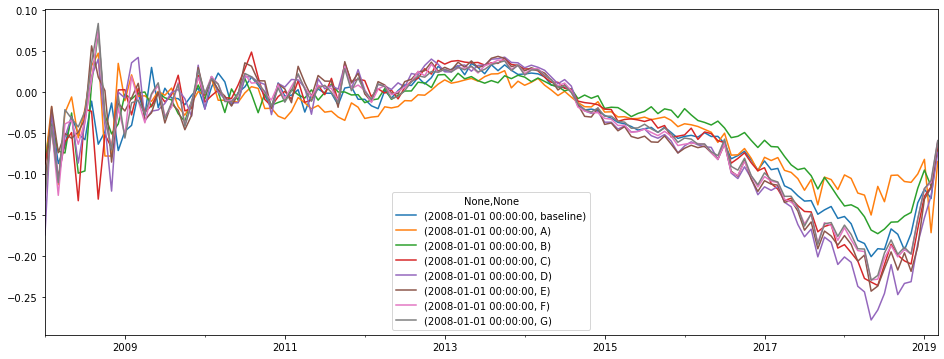

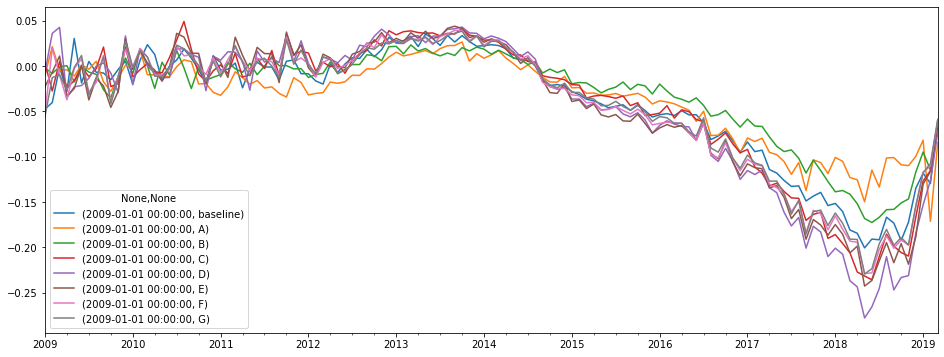

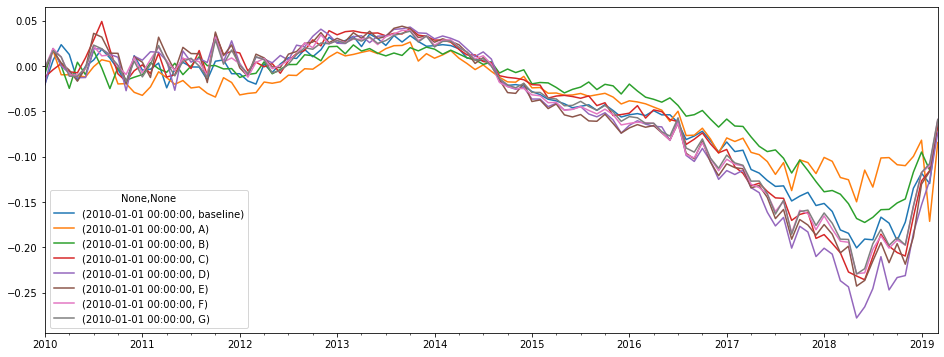

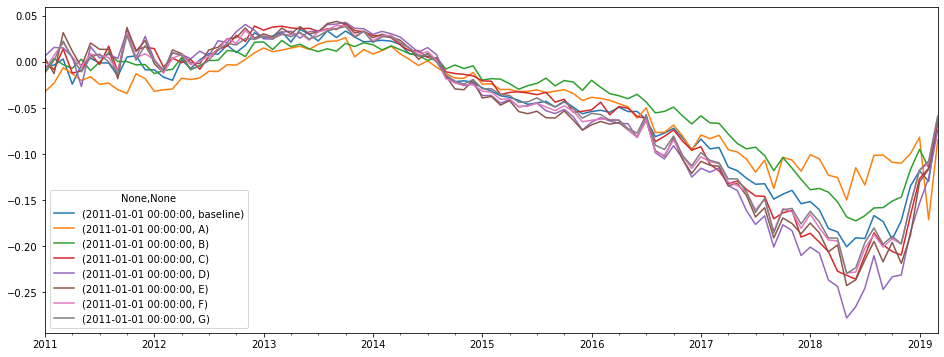

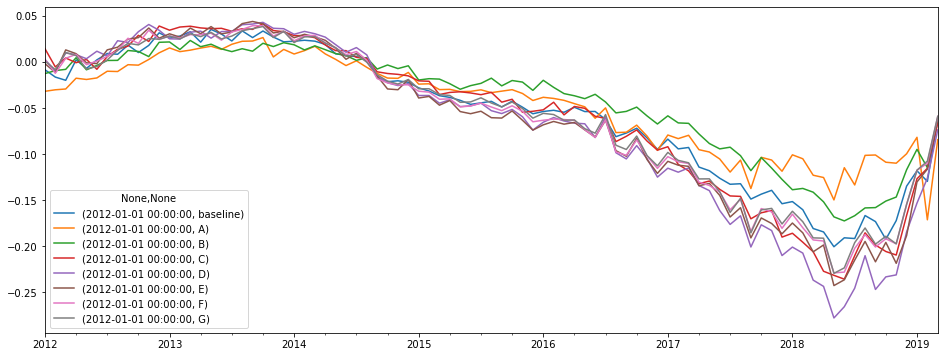

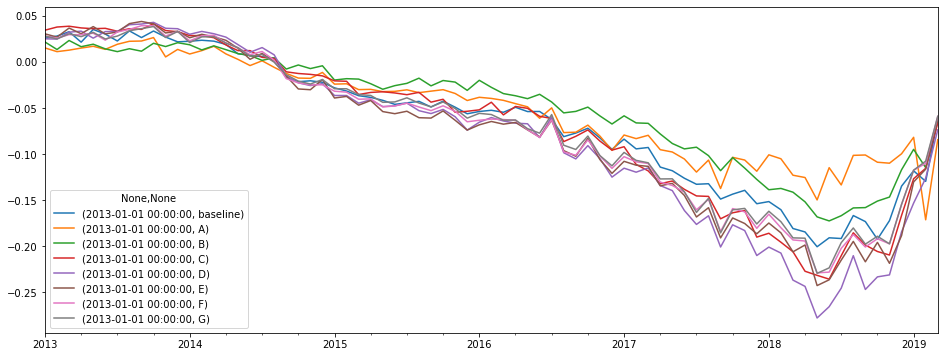

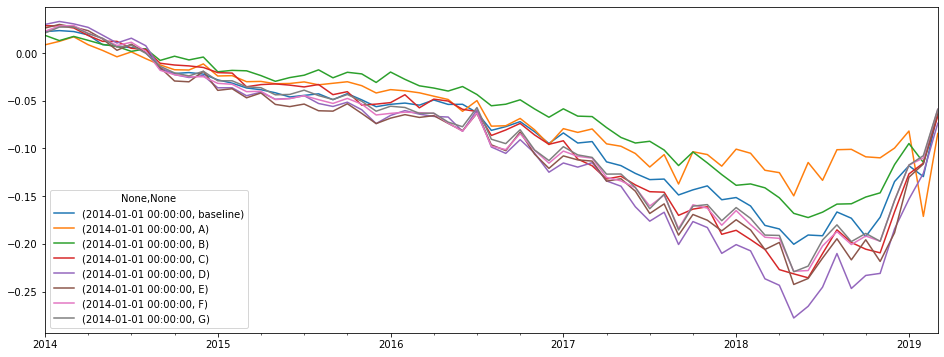

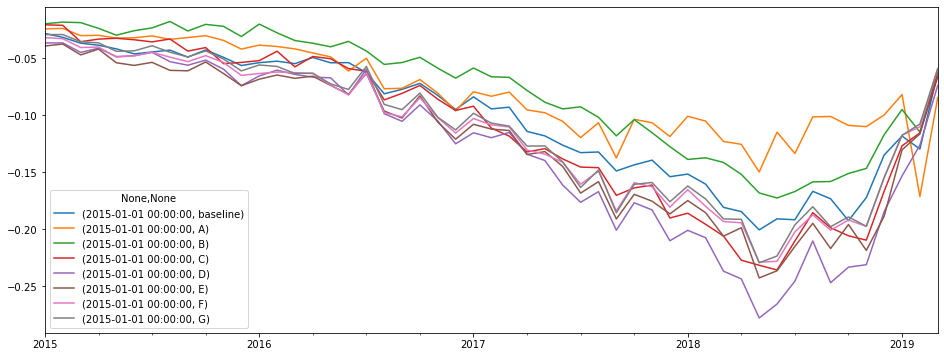

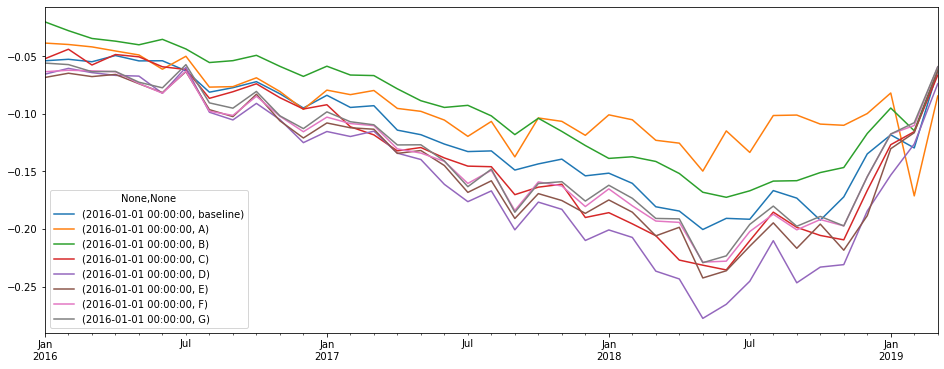

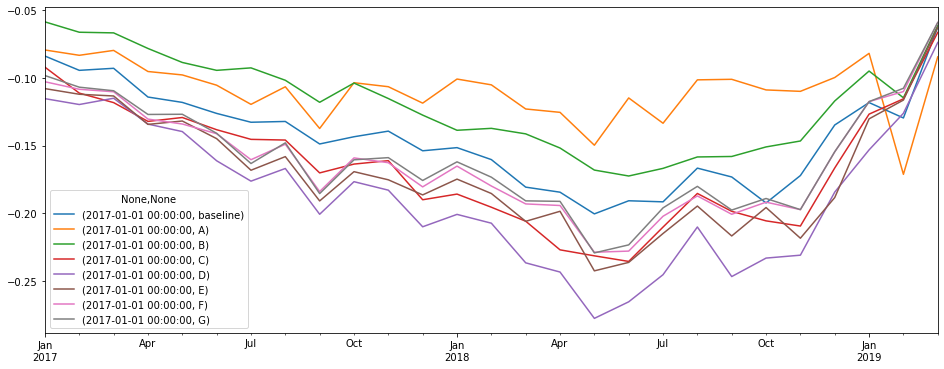

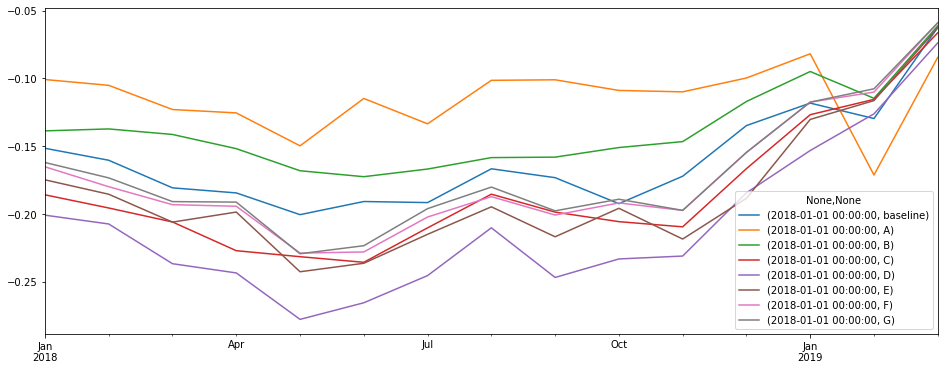

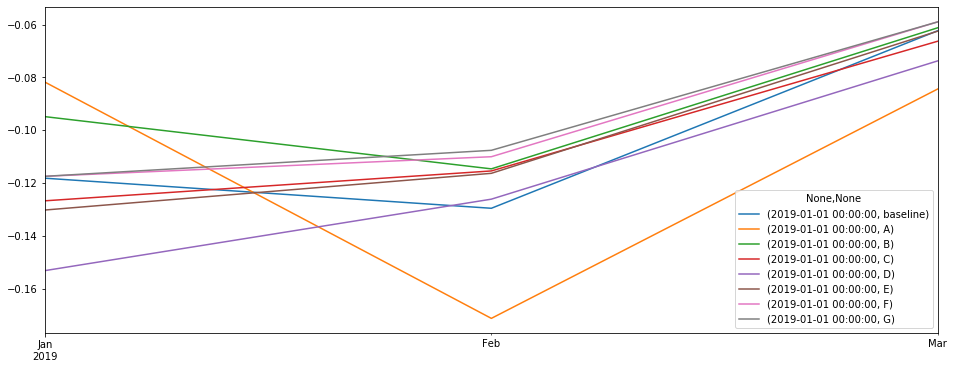

In [10]:
# month-by-month top30% of baselines and grades
reform = {(outerKey, innerKey): values for outerKey, innerDict in mbm_top30.items() for innerKey, values in innerDict.items()}
mbm_top30_df = pd.DataFrame(reform).T
mbm_top30_df.to_csv(os.path.join(dpath, 'mbm_top30_df.csv'))

for date, group in mbm_top30_df.groupby(level=0):
    ax = group.dropna(axis=1).T.plot(figsize=(16,6))

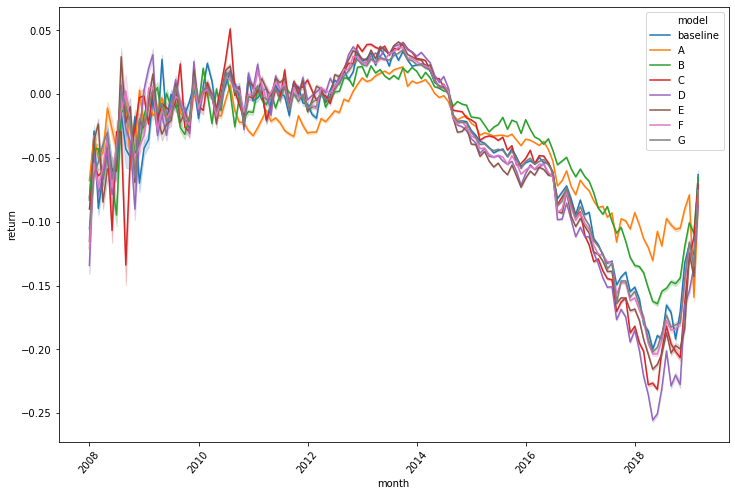

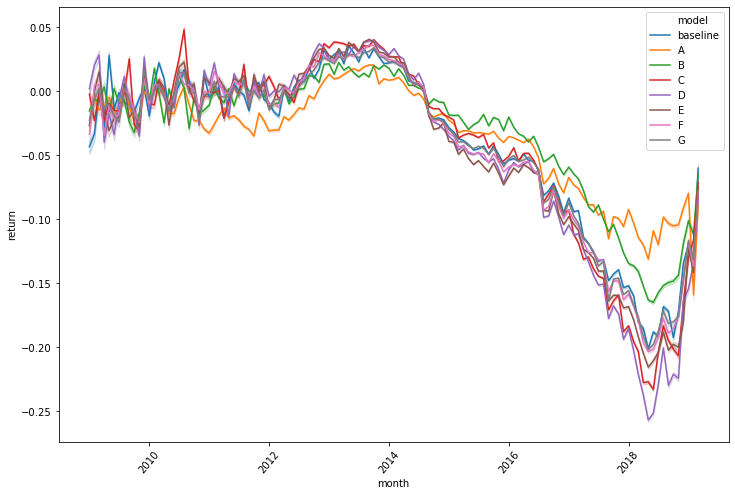

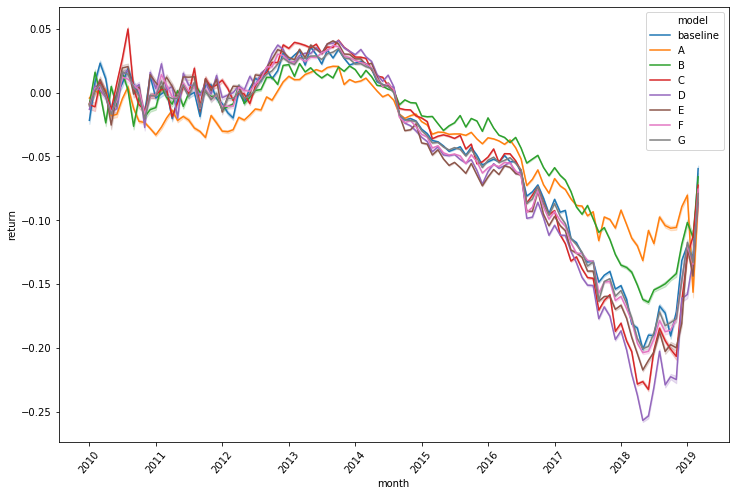

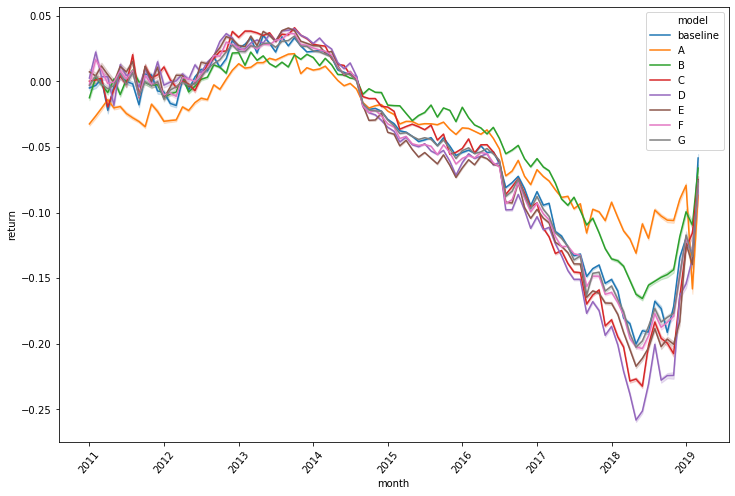

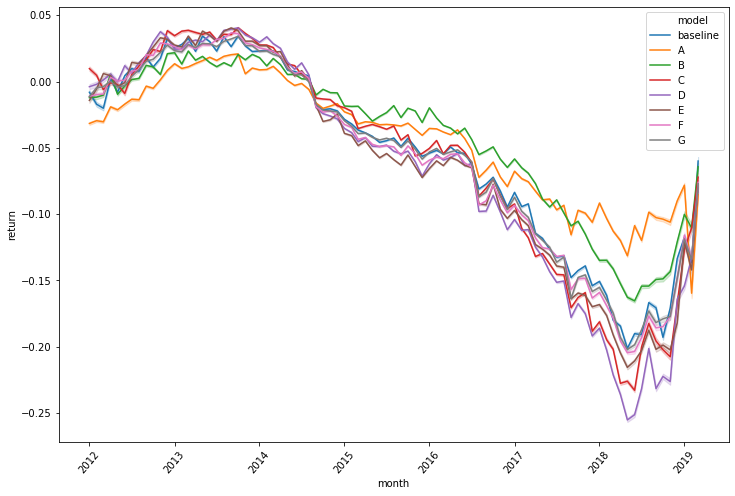

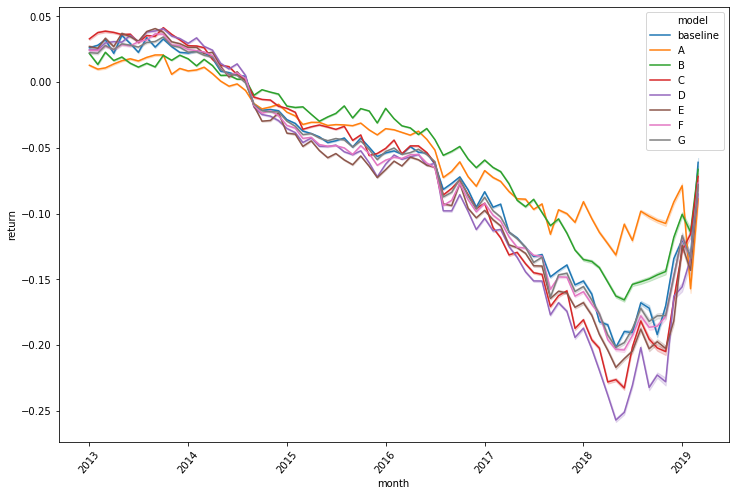

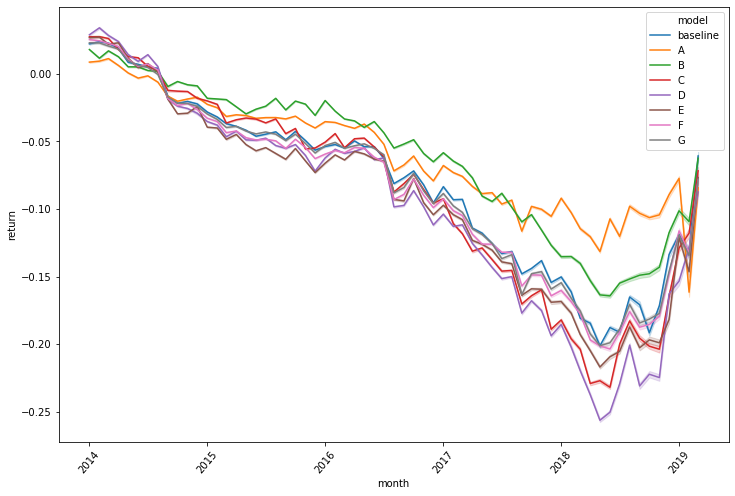

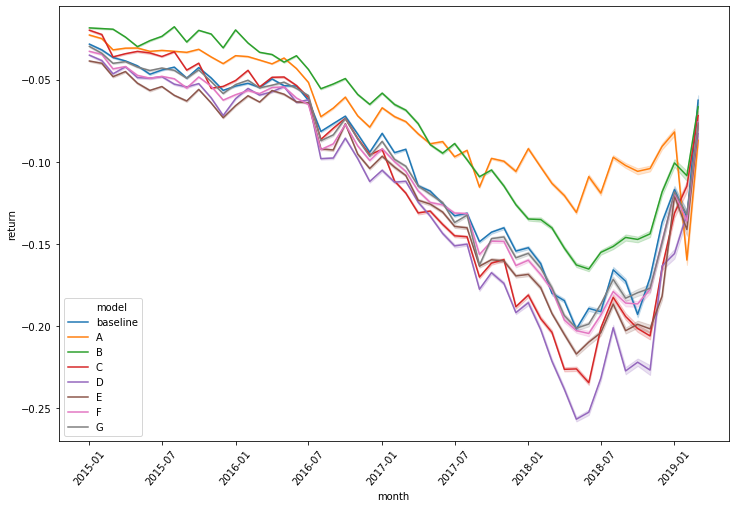

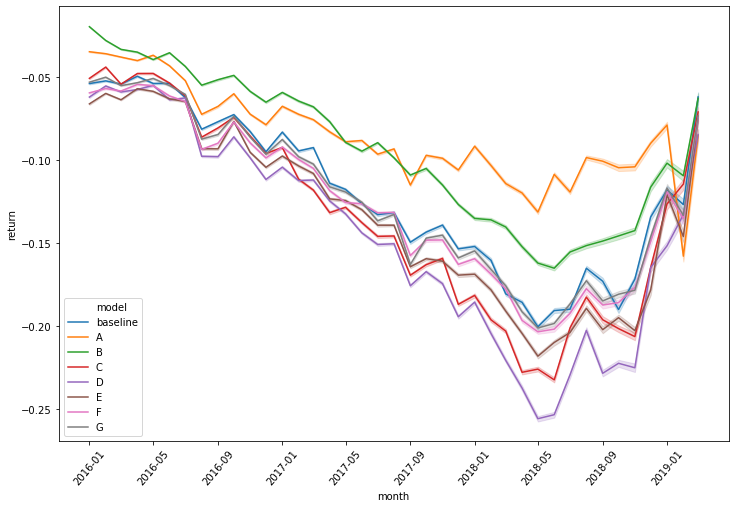

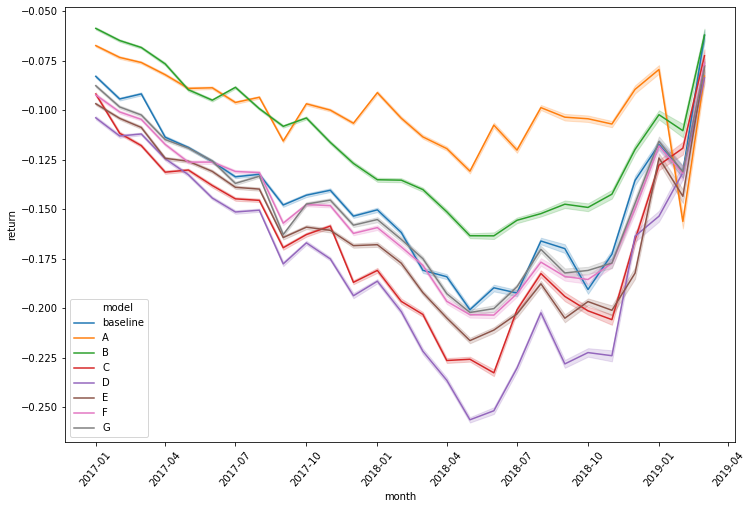

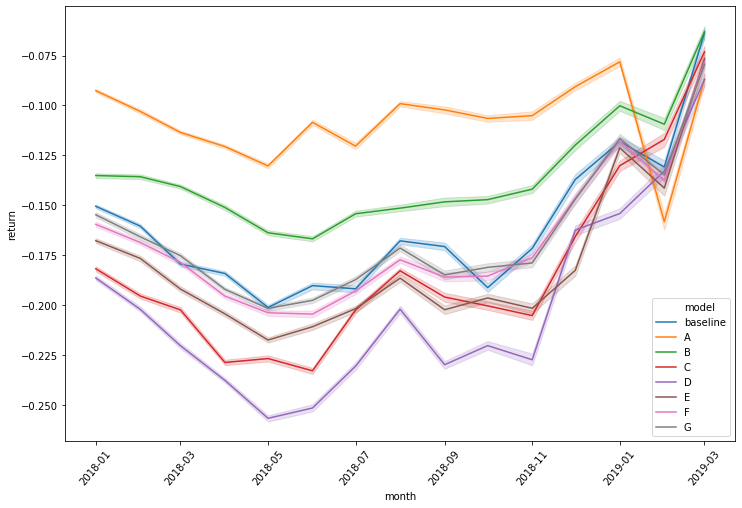

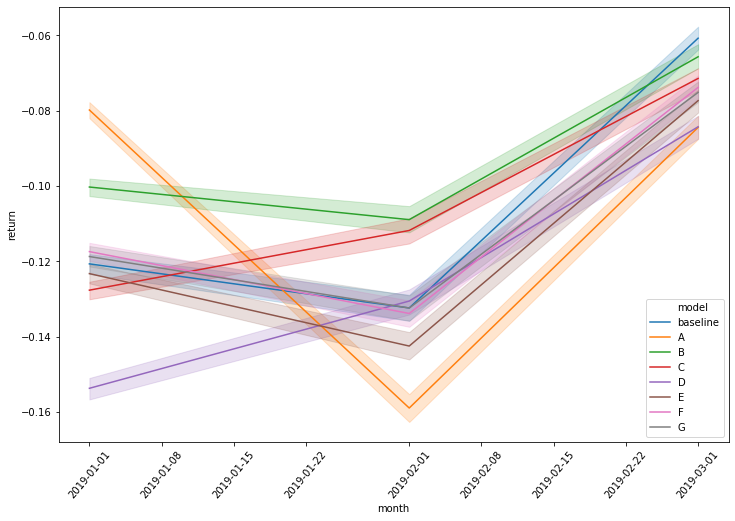

In [11]:
# bootstrap monthy-by-month top 30
reform = {(outerKey, innerKey[0], innerKey[1], monthKey): values for outerKey, innerDict in bsmbm_top30.items() for innerKey, subDict in innerDict.items() for monthKey, values in subDict.items()}
bsmbm_top30_df = pd.Series(reform).to_frame()
bsmbm_top30_df.columns = ['return']
bsmbm_top30_df.index.names=['valid_start', 'model', 'trial', 'month']
bsmbm_top30_df.reset_index(inplace=True)
bsmbm_top30_df.to_csv(os.path.join(dpath, 'bsmbm_top30_df.csv'))

for valid_start, grp in bsmbm_top30_df.groupby(['valid_start']):
    plt.figure(figsize=(12,8))
    ax = sns.lineplot(x='month', y='return', hue = 'model', data=grp)
    plt.xticks(rotation=50)
    plt.show()

100%|██████████| 5000/5000 [01:27<00:00, 57.42it/s]


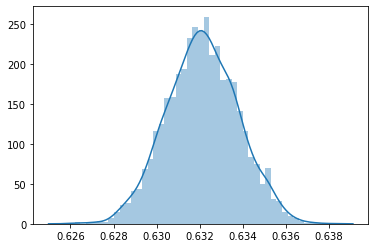

In [52]:
# check bootstrap distribution of total population loans included
ex=eval_loan_info.query('issue_d == @test_date')
def get_pct_represented(ex):
    bs_sample = ex.sample(frac=1, replace=True)
    return len(set(bs_sample['id']))/len(set(ex['id']))

res = {}
for trial in tqdm(np.arange(5000)):
    res[trial] = get_pct_represented(ex)
    
sns.distplot(pd.Series(res))

In [ ]:
# Assuming have eval_df, say we only see 1000 loans of each month (sampled randomly)
# and then choose the 300 best scored by our model as our picks that month

def pick_top_n(loans, score_col, top_n = 300):
    '''
    Given loans to pick from, the score_col to use, and top_n,
    pick min(top_n, .3*len(loans)) loans, highest score to lowest
    '''
    return loans.sort_values(score_col, ascending=False).head(min(top_n), .3*len(loans))
    

def make_trial_loans(m_eval_df, n_pick = 1000):
    '''
    Given a m_eval_df (eval_df cut to a specific month),
    return the loan_ids to pick scores from
    '''
    if n_pick < len(m_eval_df):
        return m_eval_df.sample(n_pick)
    else:
        return m_eval_df

In [10]:
eval_loan_info.head(80000)

end_d    issue_d  maturity_paid  maturity_time  \
0     2011-10-01 2009-08-01       1.000000       1.000000   
1     2010-03-01 2008-07-01       1.000000       1.000000   
2     2018-06-01 2016-08-01       1.000000       0.944444   
3     2011-06-01 2008-05-01       1.000000       1.000000   
4     2018-04-01 2016-01-01       0.583209       1.000000   
...          ...        ...            ...            ...   
79995 2015-10-01 2012-10-01       1.000000       1.000000   
79996 2015-05-01 2012-10-01       1.000000       1.000000   
79997 2015-10-01 2012-10-01       1.000000       1.000000   
79998 2015-10-01 2012-10-01       1.000000       1.000000   
79999 2015-10-01 2012-10-01       1.000000       1.000000   

       maturity_time_stat_adj  maturity_paid_stat_adj  rem_to_be_paid  \
0                         1.0                     1.0        0.000000   
1                         1.0                     1.0        0.000000   
2                         1.0                     1.0        0.000000   
3                         1.0                     1.0        0.000000   
4                         1.0                     1.0     3677.225098   
...                       ...                     ...             ...   
79995                     1.0                     1.0        0.000000   
79996                     1.0                     1.0        0.000000   
79997                     1.0                     1.0        0.000000   
79998                     1.0                     1.0        0.000000   
79999                     1.0                     1.0        0.000000   

       roi_simple  target_loose  target_strict  loan_status       id grade  \
0        1.173214             0              0         paid    54734     B   
1        1.207769             0              0         paid    55521     F   
2        1.353502             0              0         paid    55716     E   
3        1.173648             0              0         paid    55742     B   
4        0.643185             1              1  charged_off    56121     A   
...           ...           ...            ...          ...      ...   ...   
79995    1.164325             0              0         paid  1571846     B   
79996    1.177696             0              0         paid  1571856     B   
79997    1.197777             0              0         paid  1571858     B   
79998    1.288317             0              0         paid  1571871     C   
79999    1.356299             0              0         paid  1571886     E   

       int_rate  term      0.05      0.06      0.07      0.08      0.09  \
0        0.1189    36  0.095902  0.081254  0.066865  0.052729  0.038841   
1        0.1608    36  0.137690  0.124301  0.111112  0.098121  0.085324   
2        0.2499    36  0.274963  0.259472  0.244227  0.229225  0.214461   
3        0.1071    36  0.087770  0.071643  0.055847  0.040373  0.025214   
4        0.0649    36 -0.385032 -0.390533 -0.395965 -0.401330 -0.406627   
...         ...   ...       ...       ...       ...       ...       ...   
79995    0.1016    36  0.079330  0.063324  0.047647  0.032290  0.017245   
79996    0.1114    36  0.093469  0.077612  0.062069  0.046831  0.031893   
79997    0.1212    36  0.110167  0.093707  0.077585  0.061791  0.046319   
79998    0.1727    36  0.195040  0.177309  0.159941  0.142929  0.126263   
79999    0.2100    36  0.257053  0.238416  0.220160  0.202278  0.184759   

            0.1      0.11      0.12      0.13      0.14      0.15      0.16  \
0      0.025198  0.011792 -0.001379 -0.014321 -0.027038 -0.039534 -0.051815   
1      0.072718  0.060299  0.048065  0.036013  0.024139  0.012441  0.000915   
2      0.199930  0.185629  0.171554  0.157699  0.144063  0.130640  0.117426   
3      0.010362 -0.004190 -0.018448 -0.032420 -0.046112 -0.059532 -0.072685   
4     -0.411859 -0.417025 -0.422128 -0.427167 -0.432145 -0.437061 -0.441916   
...         ...       ...       ...       ...       ...       ...       ...   
79995  0.0

In [11]:
eval_loan_info[:80000]

end_d    issue_d  maturity_paid  maturity_time  \
0     2011-10-01 2009-08-01       1.000000       1.000000   
1     2010-03-01 2008-07-01       1.000000       1.000000   
2     2018-06-01 2016-08-01       1.000000       0.944444   
3     2011-06-01 2008-05-01       1.000000       1.000000   
4     2018-04-01 2016-01-01       0.583209       1.000000   
...          ...        ...            ...            ...   
79995 2015-10-01 2012-10-01       1.000000       1.000000   
79996 2015-05-01 2012-10-01       1.000000       1.000000   
79997 2015-10-01 2012-10-01       1.000000       1.000000   
79998 2015-10-01 2012-10-01       1.000000       1.000000   
79999 2015-10-01 2012-10-01       1.000000       1.000000   

       maturity_time_stat_adj  maturity_paid_stat_adj  rem_to_be_paid  \
0                         1.0                     1.0        0.000000   
1                         1.0                     1.0        0.000000   
2                         1.0                     1.0        0.000000   
3                         1.0                     1.0        0.000000   
4                         1.0                     1.0     3677.225098   
...                       ...                     ...             ...   
79995                     1.0                     1.0        0.000000   
79996                     1.0                     1.0        0.000000   
79997                     1.0                     1.0        0.000000   
79998                     1.0                     1.0        0.000000   
79999                     1.0                     1.0        0.000000   

       roi_simple  target_loose  target_strict  loan_status       id grade  \
0        1.173214             0              0         paid    54734     B   
1        1.207769             0              0         paid    55521     F   
2        1.353502             0              0         paid    55716     E   
3        1.173648             0              0         paid    55742     B   
4        0.643185             1              1  charged_off    56121     A   
...           ...           ...            ...          ...      ...   ...   
79995    1.164325             0              0         paid  1571846     B   
79996    1.177696             0              0         paid  1571856     B   
79997    1.197777             0              0         paid  1571858     B   
79998    1.288317             0              0         paid  1571871     C   
79999    1.356299             0              0         paid  1571886     E   

       int_rate  term      0.05      0.06      0.07      0.08      0.09  \
0        0.1189    36  0.095902  0.081254  0.066865  0.052729  0.038841   
1        0.1608    36  0.137690  0.124301  0.111112  0.098121  0.085324   
2        0.2499    36  0.274963  0.259472  0.244227  0.229225  0.214461   
3        0.1071    36  0.087770  0.071643  0.055847  0.040373  0.025214   
4        0.0649    36 -0.385032 -0.390533 -0.395965 -0.401330 -0.406627   
...         ...   ...       ...       ...       ...       ...       ...   
79995    0.1016    36  0.079330  0.063324  0.047647  0.032290  0.017245   
79996    0.1114    36  0.093469  0.077612  0.062069  0.046831  0.031893   
79997    0.1212    36  0.110167  0.093707  0.077585  0.061791  0.046319   
79998    0.1727    36  0.195040  0.177309  0.159941  0.142929  0.126263   
79999    0.2100    36  0.257053  0.238416  0.220160  0.202278  0.184759   

            0.1      0.11      0.12      0.13      0.14      0.15      0.16  \
0      0.025198  0.011792 -0.001379 -0.014321 -0.027038 -0.039534 -0.051815   
1      0.072718  0.060299  0.048065  0.036013  0.024139  0.012441  0.000915   
2      0.199930  0.185629  0.171554  0.157699  0.144063  0.130640  0.117426   
3      0.010362 -0.004190 -0.018448 -0.032420 -0.046112 -0.059532 -0.072685   
4     -0.411859 -0.417025 -0.422128 -0.427167 -0.432145 -0.437061 -0.441916   
...         ...       ...       ...       ...       ...       ...       ...   
79995  0.0

In [ ]:
eval_loan_info.sample()

In [9]:
test_month_ids_dict = {}
for date in test_dates:
    
    test_month_ids_dict[date] = 

[Timestamp('2008-01-01 00:00:00'),
 Timestamp('2009-01-01 00:00:00'),
 Timestamp('2010-01-01 00:00:00'),
 Timestamp('2011-01-01 00:00:00'),
 Timestamp('2012-01-01 00:00:00'),
 Timestamp('2013-01-01 00:00:00'),
 Timestamp('2014-01-01 00:00:00'),
 Timestamp('2015-01-01 00:00:00'),
 Timestamp('2016-01-01 00:00:00'),
 Timestamp('2017-01-01 00:00:00'),
 Timestamp('2018-01-01 00:00:00'),
 Timestamp('2019-01-01 00:00:00')]

In [8]:
def trial_baseline_models():
    '''
    given model and dataset, return month_by_month picked loan_ids and scores
    for baseline, scores just assume all are 1 aka all loans don't default
    
    Args:
        
    
    return:
        id_scores_df: pd.DataFrame, rows are ids and scores
        columns are months.
        cell contents are np.array
    '''
    
    
def get_ids_scores(model_name, df):
    '''
    Given a model_name and a dataframe of loans, returns a dataframe of the 
    loan_ids and scores (in numpy arrays)
    '''
    
    model = Model(model_name)
    scores = model.score(df)
    ids = df.id.values
    
    return pd.DataFrame({'id': ids, 'scores': scores})


def get_m_by_m_rets(model_name, df, eval_df):
    '''
    Given a model_name and a df (treated as test set), return the returns month by month
    '''
    # cut eval_df to same as df
    test_ids = df['id']
    eval_df = eval_df.query('id == @test_ids')
    ids_scores = get_ids_scores(model_name, df)
    eval_df = eval_df.merge(ids_scores, on='id')
    
    # setup all the months that I need to get returns from
    for d in sorted(eval_df['issue_d'].unique()):
        
    
    
    return eval_df, ids_scores

In [42]:
def test_1():
    ix = np.random.randint(0, len(eval_loan_info), round(len(eval_loan_info)*.1))
    eval_loan_info.iloc[ix]
    
def test_2():
    eval_loan_info.sample(round(len(eval_loan_info)*.1))
    
def test_3():
    ix = np.random.choice(np.arange(len(eval_loan_info)), round(len(eval_loan_info)*.1), replace=False)
    eval_loan_info.iloc[ix]

In [70]:
%timeit len(eval_df)

546 ns ± 3.76 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [71]:
%timeit eval_df.shape

755 ns ± 2.88 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [61]:
np.arange??

In [52]:
import pickle

In [53]:
train_test_ids = pickle.load( open( os.path.join(dpath, 'train_test_ids_dict.pkl'), "rb" ) )

In [55]:
train_test_ids.keys()

dict_keys([1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24])

In [57]:
train_test_ids[1]

2

In [50]:
ls {dpath}

base_loan_info.fth*              loan_info.fth*
clean_pmt_history_1.fth*         npv_roi_df.fth
clean_pmt_history_2.fth*         raw_loan_info.fth*
clean_pmt_history_3.fth*         scaled_pmt_hist.fth*
csvs/                            strings_loan_info_df.fth*
eval_loan_info.fth*              str_loan_info.fth*
example.py*                      train_test_ids_dict.pkl
loan_info_api_name_matched.fth*


In [49]:
%timeit test_1()

155 ms ± 95.1 µs per loop (mean ± std. dev. of 7 runs, 10 loops each)


In [48]:
%timeit test_2()

217 ms ± 442 µs per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [47]:
%timeit test_3()

222 ms ± 5.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [46]:
eval_loan_info.sample??

In [25]:
round(len(eval_loan_info)*.1)

237620

In [13]:
model_name = 'A'
for test_date in test_dates[-2:-1]:
    today = test_date + pd.DateOffset(months=-1)
    train_x, train_y, test_x, test_y, train_ids, test_ids = gen_datasets(today, test_date, base_loan_info, eval_loan_info, '0.07')
    eval_df, ids_scores = get_m_by_m_rets(model_name, test_x, eval_loan_info)

/home/justin/anaconda3/lib/python3.6/site-packages/pandas/core/frame.py:3295: PerformanceWarning: Alignment difference on axis 0 is larger than an order of magnitude on term '__pd_eval_local_test_ids', by more than 6.359; performance may suffer
  return _eval(expr, inplace=inplace, **kwargs)


In [14]:
print(today, test_date)
print(test_x.shape, len(test_ids), eval_df.shape)

2017-12-01 00:00:00 2018-01-01 00:00:00
(89937, 103) 89937 (89937, 47)


In [15]:
eval_df = eval_df.merge(ids_scores, on='id')

[numpy.datetime64('2018-01-01T00:00:00.000000000'),
 numpy.datetime64('2018-02-01T00:00:00.000000000'),
 numpy.datetime64('2018-03-01T00:00:00.000000000'),
 numpy.datetime64('2018-04-01T00:00:00.000000000'),
 numpy.datetime64('2018-05-01T00:00:00.000000000'),
 numpy.datetime64('2018-06-01T00:00:00.000000000'),
 numpy.datetime64('2018-07-01T00:00:00.000000000'),
 numpy.datetime64('2018-08-01T00:00:00.000000000'),
 numpy.datetime64('2018-09-01T00:00:00.000000000'),
 numpy.datetime64('2018-10-01T00:00:00.000000000'),
 numpy.datetime64('2018-11-01T00:00:00.000000000'),
 numpy.datetime64('2018-12-01T00:00:00.000000000'),
 numpy.datetime64('2019-01-01T00:00:00.000000000'),
 numpy.datetime64('2019-02-01T00:00:00.000000000'),
 numpy.datetime64('2019-03-01T00:00:00.000000000')]

In [ ]:
for 
gen_datasets()

In [42]:
valid_ids

NameError: name 'valid_ids' is not defined

In [38]:
eval_loan_info.head()

end_d    issue_d  maturity_paid  maturity_time  maturity_time_stat_adj  \
0 2011-10-01 2009-08-01       1.000000       1.000000                     1.0   
1 2010-03-01 2008-07-01       1.000000       1.000000                     1.0   
2 2018-06-01 2016-08-01       1.000000       0.944444                     1.0   
3 2011-06-01 2008-05-01       1.000000       1.000000                     1.0   
4 2018-04-01 2016-01-01       0.583209       1.000000                     1.0   

   maturity_paid_stat_adj  rem_to_be_paid  roi_simple  target_loose  \
0                     1.0        0.000000    1.173214             0   
1                     1.0        0.000000    1.207769             0   
2                     1.0        0.000000    1.353502             0   
3                     1.0        0.000000    1.173648             0   
4                     1.0     3677.225098    0.643185             1   

   target_strict  loan_status     id grade  int_rate  term      0.05  \
0              0         paid  54734     B    0.1189    36  0.095902   
1              0         paid  55521     F    0.1608    36  0.137690   
2              0         paid  55716     E    0.2499    36  0.274963   
3              0         paid  55742     B    0.1071    36  0.087770   
4              1  charged_off  56121     A    0.0649    36 -0.385032   

       0.06      0.07      0.08      0.09       0.1      0.11      0.12  \
0  0.081254  0.066865  0.052729  0.038841  0.025198  0.011792 -0.001379   
1  0.124301  0.111112  0.098121  0.085324  0.072718  0.060299  0.048065   
2  0.259472  0.244227  0.229225  0.214461  0.199930  0.185629  0.171554   
3  0.071643  0.055847  0.040373  0.025214  0.010362 -0.004190 -0.018448   
4 -0.390533 -0.395965 -0.401330 -0.406627 -0.411859 -0.417025 -0.422128   

       0.13      0.14      0.15      0.16      0.17      0.18      0.19  \
0 -0.014321 -0.027038 -0.039534 -0.051815 -0.063884 -0.075745 -0.087403   
1  0.036013  0.024139  0.012441  0.000915 -0.010441 -0.021630 -0.032654   
2  0.157699  0.144063  0.130640  0.117426  0.104419  0.091615  0.079009   
3 -0.032420 -0.046112 -0.059532 -0.072685 -0.085577 -0.098215 -0.110604   
4 -0.427167 -0.432145 -0.437061 -0.441916 -0.446713 -0.451450 -0.456130   

        0.2      0.21      0.22      0.23      0.24      0.25      0.26  \
0 -0.098861 -0.110124 -0.121195 -0.132078 -0.142776 -0.153294 -0.163634   
1 -0.043517 -0.054222 -0.064770 -0.075164 -0.085407 -0.095501 -0.105449   
2  0.066600  0.054382  0.042352  0.030509  0.018847  0.007364 -0.003943   
3 -0.122751 -0.134660 -0.146337 -0.157788 -0.169018 -0.180031 -0.190833   
4 -0.460753 -0.465320 -0.469831 -0.474288 -0.478691 -0.483042 -0.487340   

       0.27      0.28      0.29       0.3      0.31      0.32      0.33  \
0 -0.173800 -0.183796 -0.193624 -0.203289 -0.212792 -0.222138 -0.231329   
1 -0.115253 -0.124916 -0.134439 -0.143825 -0.153077 -0.162196 -0.171184   
2 -0.015077 -0.026041 -0.036838 -0.047472 -0.057944 -0.068258 -0.078416   
3 -0.201429 -0.211822 -0.222018 -0.232022 -0.241836 -0.251467 -0.260917   
4 -0.491586 -0.495782 -0.499928 -0.504025 -0.508072 -0.512072 -0.516025   

       0.34      0.35  
0 -0.240368 -0.249259  
1 -0.180044 -0.188778  
2 -0.088421 -0.098276  
3 -0.270191 -0.279292  
4 -0.519931 -0.523792

In [21]:
test_x.shape

(1472731, 103)

In [22]:
test.shape

(1472731, 46)

In [16]:
test['issue_d'].value_counts(dropna=False)

2016-03-01    55404
2015-10-01    43590
2015-07-01    41606
2015-12-01    39654
2014-10-01    36499
              ...  
2008-06-01      124
2008-10-01      122
2008-05-01      115
2008-08-01      100
2008-09-01       57
Name: issue_d, Length: 135, dtype: int64

In [17]:
test_x.shape

(1472731, 103)

In [12]:
get_ids_scores('A', base_loan_info)

{'ids': array([    54734,     55521,     55716, ..., 149522565, 149522671,
        149522875], dtype=int32),
 'scores': array([0.        , 0.        , 0.56805557, ..., 0.04195467, 0.02020119,
        0.22575813])}

In [13]:
ret_dict = {test_dates[0]: {'ids': np.array([100, 101]), 'scores': [.9, .8]}, test_dates[1]: {'ids': [200, 201], 'scores': [.5, .65]}}

In [14]:
ex = pd.DataFrame(ret_dict)
ex

2008-01-01   2009-01-01
ids     [100, 101]   [200, 201]
scores  [0.9, 0.8]  [0.5, 0.65]

In [15]:
ex.loc['ids', '2008-1-1']

array([100, 101])

In [16]:
pd.Series(['a', 'b', 'c']).to_list()

['a', 'b', 'c']

In [108]:
def basic_models(trials: int,
                 port_size: int,
                 available_loans: int,
                 grade: str,
                 eval_loan_info: pd.DataFrame,
#                  eval_loan_info: pd.DataFrame,
                 target: str) -> pd.DataFrame:
    results = {}
    pct_default = {}
    if grade:
        eval_loan_info = eval_loan_info[eval_loan_info['grade'] == grade]
    for trial in np.arange(trials):
        loans_to_pick_from = np.random.choice(
            eval_loan_info.index.values, available_loans, replace=False)
        picks = np.random.choice(loans_to_pick_from, port_size, replace=False)
        picked = eval_loan_info.loc[picks, :]
        results[trial] = picked.mean().to_dict()
        pct_default[trial] = (picked[target].sum()) / port_size
    pct_target = pd.Series(pct_default)
    results_df = pd.DataFrame(results).T
    results_df['pct_def'] = pct_target
#     if not grade:
#         results_df = results_df.add_prefix('baseline_')
#     else:
#         results_df = results_df.add_prefix(grade + '_')
    if not grade:
        grade = 'baseline'
    results_df.columns = zip(results_df.columns.values,[grade]*len(results_df.columns.values))
    return results_df

In [115]:
basic_models(15, 10, 100, 'A', test[['grade','0.07']], '0.07')

(0.07, A)  (pct_def, A)
0   -0.465350     -0.465350
1   -0.185774     -0.185774
2   -0.532520     -0.532520
3   -0.150455     -0.150455
4   -0.359090     -0.359090
5   -0.150862     -0.150862
6   -0.221728     -0.221728
7   -0.382397     -0.382397
8   -0.095169     -0.095169
9   -0.486957     -0.486957
10  -0.230482     -0.230482
11  -0.445336     -0.445336
12  -0.514698     -0.514698
13  -0.279616     -0.279616
14  -0.355887     -0.355887

In [112]:
def baseline_models():
    today = test_start + pd.DateOffset(months=-1)
    train_x, train_y, test_x, test_y, train_ids, test_ids = gen_datasets(today, test_start, base_loan_info, eval_loan_info, '0.07')
    test = eval_loan_info.query('id == test_ids')
    grades = [None]
    grades.extend(sorted(test.grade.unique().tolist()))
    grade_counts = test.grade.value_counts(dropna=False)

In [100]:
for test_start in test_dates:
    


2007-12-01 00:00:00
2008-12-01 00:00:00
2009-12-01 00:00:00
2010-12-01 00:00:00
2011-12-01 00:00:00
2012-12-01 00:00:00
2013-12-01 00:00:00
2014-12-01 00:00:00
2015-12-01 00:00:00
2016-12-01 00:00:00
2017-12-01 00:00:00
2018-12-01 00:00:00


In [53]:
trials = 5000
available_loans = 3000
grades_available_loans = [
    int(min(grade_counts[grade] * .2, available_loans))
    if grade else available_loans for grade in grades
]
grades_port_size = [int(.3*n_loans) for n_loans in grades_available_loans]
grade_batch_loans = dict(zip(grades, zip(grades_available_loans,grades_port_size)))

In [58]:
results_dict = {}
for grade in tqdm(grades):
    results_dict[grade] = basic_models(trials, grade_batch_loans[grade][1],
                                       grade_batch_loans[grade][0], grade,
                                       test, 'target_strict')



 10%|█         | 519/5000 [00:30<01:46, 42.24it/s]

 12%|█▎        | 1/8 [01:47<12:33, 107.57s/it]

 25%|██▌       | 2/8 [03:22<10:23, 103.88s/it]

 38%|███▊      | 3/8 [04:58<08:26, 101.29s/it]

 50%|█████     | 4/8 [06:33<06:37, 99.40s/it] 

 62%|██████▎   | 5/8 [08:05<04:52, 97.45s/it]

 75%|███████▌  | 6/8 [09:26<03:04, 92.46s/it]

 88%|████████▊ | 7/8 [10:19<01:20, 80.68s/it]

100%|██████████| 8/8 [11:01<00:00, 68.86s/it]

In [59]:
result = pd.concat(results_dict.values(), axis=1)
result.columns = pd.MultiIndex.from_tuples(
    result.columns.values, names=['discount_rate', 'model'])
result.sort_index(axis=1, inplace = True)

In [60]:
result

discount_rate      0.05                                                    \
model                 A         B         C         D         E         F   
0             -0.009711 -0.008412 -0.038056 -0.068693 -0.093992 -0.128010   
1             -0.013193 -0.013524 -0.045405 -0.058433 -0.098746 -0.177716   
2             -0.010689  0.000243 -0.056899 -0.042729 -0.092016 -0.171296   
3             -0.001551 -0.007234 -0.037483 -0.035447 -0.104864 -0.175998   
4             -0.008115 -0.016662 -0.020231 -0.054902 -0.101201 -0.169303   
...                 ...       ...       ...       ...       ...       ...   
4995          -0.007554 -0.015760 -0.039637 -0.053316 -0.099473 -0.156181   
4996          -0.010658 -0.003085 -0.033121 -0.040581 -0.092433 -0.127376   
4997           0.000998 -0.005982 -0.028836 -0.056817 -0.096337 -0.149875   
4998          -0.003240 -0.002453 -0.032831 -0.038028 -0.108544 -0.147641   
4999          -0.015405 -0.009285 -0.045182 -0.042807 -0.107061 -0.194072   

discount_rate                          0.06                                \
model                 G  baseline         A         B         C         D   
0             -0.160721 -0.021373 -0.021720 -0.020099 -0.049104 -0.078739   
1             -0.243728 -0.027517 -0.025393 -0.025287 -0.056202 -0.068779   
2             -0.110765 -0.033229 -0.022792 -0.011547 -0.067632 -0.053458   
3             -0.193312 -0.049755 -0.013557 -0.018739 -0.048547 -0.045966   
4             -0.113799 -0.036473 -0.020041 -0.028310 -0.031698 -0.065209   
...                 ...       ...       ...       ...       ...       ...   
4995          -0.217459 -0.022225 -0.019816 -0.027383 -0.050412 -0.063683   
4996          -0.142746 -0.032295 -0.022661 -0.014921 -0.044351 -0.051250   
4997          -0.239149 -0.018201 -0.011267 -0.017667 -0.040014 -0.067146   
4998          -0.261499 -0.016005 -0.015359 -0.014174 -0.043730 -0.048381   
4999          -0.186275 -0.030425 -0.027129 -0.020942 -0.056153 -0.053340   

discount_rate                                              0.07            \
model                 E         F         G  baseline         A         B   
0             -0.103806 -0.136913 -0.169383 -0.032624 -0.033513 -0.031580   
1             -0.108145 -0.185895 -0.250376 -0.038805 -0.037374 -0.036842   
2             -0.101839 -0.179540 -0.119822 -0.044437 -0.034678 -0.023131   
3             -0.114266 -0.184511 -0.201480 -0.060691 -0.025351 -0.030043   
4             -0.110579 -0.177448 -0.122973 -0.047870 -0.031757 -0.039755   
...                 ...       ...       ...       ...       ...       ...   
4995          -0.109036 -0.164359 -0.224726 -0.033614 -0.031857 -0.038803   
4996          -0.102147 -0.136476 -0.151418 -0.043518 -0.034450 -0.026550   
4997          -0.106271 -0.158245 -0.245749 -0.029600 -0.023312 -0.029147   
4998          -0.118104 -0.156404 -0.267827 -0.027647 -0.027263 -0.025690   
4999          -0.116425 -0.202214 -0.193968 -0.041633 -0.038648 -0.032395   

discount_rate                                                              \
model                 C         D         E         F         G  baseline   
0             -0.059961 -0.088615 -0.113456 -0.145670 -0.177906 -0.043680   
1             -0.066813 -0.078950 -0.117389 -0.193943 -0.256925 -0.049897   
2             -0.078179 -0.064000 -0.111495 -0.187652 -0.128735 -0.055448   
3             -0.059419 -0.056307 -0.123511 -0.192883 -0.209514 -0.071437   
4             -0.042967 -0.075342 -0.119802 -0.185464 -0.131994 -0.059067   
...                 ...       ...       ...       ...       ...       ...   
4995          -0.061004 -0.073874 -0.118438 -0.172409 -0.231877 -0.044805   
4996          -0.055386 -0.061735 -0.111697 -0.145426 -0.159947 -0.054546   
4997          -0.050998 -0.077302 -0.116035 -0.166480 -0.252248 -0.040801   
4998          -0.054442 -0.058561 -0.127503 -0.165025 -0.274063 -0.039082   
4999          -0.066935 -0.063695 -0.125635 -0.210221 -0.201536 -0.052

In [61]:
result.describe()

discount_rate         0.05                                         \
model                    A            B            C            D   
count          5000.000000  5000.000000  5000.000000  5000.000000   
mean             -0.008814    -0.011129    -0.029937    -0.050919   
std               0.004133     0.006667     0.008974     0.010981   
min              -0.023944    -0.033956    -0.062061    -0.090261   
25%              -0.011475    -0.015668    -0.035950    -0.058131   
50%              -0.008725    -0.011086    -0.029853    -0.050780   
75%              -0.005996    -0.006504    -0.023905    -0.043468   
max               0.005727     0.010540     0.004491    -0.017651   

discount_rate                                                      \
model                    E            F            G     baseline   
count          5000.000000  5000.000000  5000.000000  5000.000000   
mean             -0.098044    -0.153206    -0.177243    -0.029970   
std               0.014066     0.024023     0.050683     0.008260   
min              -0.145640    -0.238376    -0.374621    -0.059709   
25%              -0.107840    -0.169657    -0.211918    -0.035552   
50%              -0.098078    -0.152327    -0.176809    -0.029911   
75%              -0.088557    -0.136874    -0.142855    -0.024383   
max              -0.047547    -0.075144     0.000594    -0.001786   

discount_rate         0.06                                         \
model                    A            B            C            D   
count          5000.000000  5000.000000  5000.000000  5000.000000   
mean             -0.020866    -0.022851    -0.041035    -0.061339   
std               0.004070     0.006560     0.008832     0.010813   
min              -0.035718    -0.045455    -0.072721    -0.100256   
25%              -0.023501    -0.027283    -0.046976    -0.068369   
50%              -0.020770    -0.022830    -0.040929    -0.061250   
75%              -0.018082    -0.018297    -0.035087    -0.054005   
max              -0.006529    -0.001599    -0.007197    -0.028656   

discount_rate                                                      \
model                    E            F            G     baseline   
count          5000.000000  5000.000000  5000.000000  5000.000000   
mean             -0.107614    -0.161654    -0.185273    -0.041201   
std               0.013858     0.023688     0.049968     0.008128   
min              -0.154513    -0.245801    -0.380461    -0.070388   
25%              -0.117223    -0.177893    -0.219421    -0.046691   
50%              -0.107586    -0.160706    -0.184833    -0.041129   
75%              -0.098326    -0.145530    -0.151394    -0.035691   
max              -0.057874    -0.084618    -0.009788    -0.013465   

discount_rate         0.07                                         \
model                    A            B            C            D   
count          5000.000000  5000.000000  5000.000000  5000.000000   
mean             -0.032703    -0.034368    -0.051941    -0.071583   
std               0.004011     0.006458     0.008694     0.010651   
min              -0.047281    -0.056753    -0.083197    -0.110081   
25%              -0.035305    -0.038729    -0.057774    -0.078543   
50%              -0.032611    -0.034345    -0.051842    -0.071483   
75%              -0.029960    -0.029838    -0.046095    -0.064377   
max              -0.018568    -0.013523    -0.018682    -0.039472   

discount_rate                                                      \
model                    E            F            G     baseline   
count          5000.000000  5000.000000  5000.000000  5000.000000   
mean             -0.117023    -0.169966    -0.193174    -0.052238   
std               0.013656     0.023362     0.049271     0.008001   
min              -0.163240    -0.253108    -0.386209    -0.080881   
25%              -0.126409    -0.185970    -0.226851    -0.057629   
50%              -0.116991    -0.169148    -0.192660    -0.052

In [65]:
pd.__version__

'0.25.0'

In [66]:
data = np.random.randint(1, 10, (5, 3, 2))
pnl = pd.Panel(
    data, 
    items=['item {}'.format(i) for i in range(1, 6)], 
    major_axis=[2015, 2016, 2017], 
    minor_axis=['US', 'UK']
)

TypeError: object() takes no parameters

In [ ]:
store.open()
store['results'] = result
store.close()